출처: https://www.kaggle.com/code/gpreda/porto-seguro-exploratory-analysis-and-prediction/notebook

# Introduction

이 notebook은 다음의 커널들을 참고해 만들었습니다.

- [Data Preparation and Exploration](https://www.kaggle.com/bertcarremans/data-preparation-exploration) by Bert Carremans.
- [Steering Whell of Fortune - Porto Seguro EDA](https://www.kaggle.com/headsortails/steering-wheel-of-fortune-porto-seguro-eda) by Heads or Tails
- [Interactive Porto Insights - A Plot.ly Tutorial](https://www.kaggle.com/arthurtok/interactive-porto-insights-a-plot-ly-tutorial) by Anisotropic
- [Simple Stacker](https://www.kaggle.com/yekenot/simple-stacker-lb-0-284) by Vladimir Demidov

# Analysis packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

pd.set_option("display.max_columns", 100)

# Load the data

In [ ]:
trainset = pd.read_csv("../input/porto-seguro-safe-driver-prediction/train.csv")
testset = pd.read_csv("../input/porto-seguro-safe-driver-prediction/test.csv")

# Few quick observations

이 대회에서의 데이터 설명을 통해 몇가지를 발견할 수 있습니다.

- 설명되어 있는 그룹이 거의 없으며 이러한 그룹들에 속한 feature들은 이름에 패턴을 포함하고 있습니다. (ind, reg, car, calc). **ind**는 **개개인**을 나타내고, **reg**는 **등록여부**, **car**는 따로 설명할 필요가 없고, **calc**는 계산된 필드를 암시할 것입니다
- 접미사 **bin**은 binary features
- 접미사 **cat**은 categorical features
- **bin**이나 **cat**이 없는 feature은 실수(연속형)나 정수(순서형)입니다
- 결측치는 **-1**입니다
- 우리가 예측해야할 변수는 **target** 칼럼입니다. 이는 피보험자의 보험 청구여부를 나타냅니다.

In [ ]:
trainset.head()

정말로 **cat**이 접미사로 붙은 feature들은 **범주형**이고, 정수값은 0에서 n까지, **bin** feature들은 0 혹은 1의 값을 가지는 것을 확인할 수 있습니다.


<br>
<br>
<br>


데이터 세트의 shape을 확인해봅니다.

In [ ]:
print("Train dataset (rows, cols):",trainset.shape, "\nTest dataset (rows, cols):",testset.shape)

칼럼의 개수가 차이나는 이유는 target 칼럼의 유무

In [ ]:
print("Columns in train and not in test dataset:",set(trainset.columns)-set(testset.columns))

# Introduction of metadata

데이터 다루는 것을 쉽게 하기 위하여, 변수들에 대한 meta-information을 담은 데이터프레임을 만들어줍니다. 이는 다양한 변수를 가진 feature들의  조사, 검사, 모델링하는데 용이하게 해줍니다.

메타데이터로 사용할 것들:

- **use**: input, ID, target
- **type**: nominal, interval, ordinal, binary
- **preserve**: True or False
- **dataType**: int, float, char
- **category**: ind, reg, car, calc

In [ ]:
data = []
for feature in trainset.columns:
    # Defining the role
    if feature == "target":
        use = "target"
    elif feature == "id":
        use = "id"
    else:
        use = "input"
        
    # Defining the type
    if "bin" in feature or feature == "target":
        type = "binary"
    elif "cat" in feature or feature == "id":
        type = "categorical"
    elif np.issubdtype(trainset[feature].dtype, np.floating):
        type = "real"
    elif np.issubdtype(trainset[feature].dtype, np.integer):
        type = "integer"
        
    # id를 제외하고 모든 변수들을 preverse = Ture로 설정
    preserve = True
    if feature == "id":
        preserve = False
        
    # Defining the data type
    dtype = trainset[feature].dtype
    
    category = "none"
    # Defining the category
    if "ind" in feature:
        category = "individual"
    elif "reg" in feature:
        category = "registration"
    elif "car" in feature:
        category = "car"
    elif "calc" in feature:
        category = "calculated"
        
    feature_dictionary = {
        'varname': feature,
        'use': use,
        'type': type,
        'preserve': preserve,
        'dtype': dtype,
        'category' : category
    }
    
    data.append(feature_dictionary)
    
metadata = pd.DataFrame(data, columns=['varname', 'use', 'type', 'preserve', 'dtype', 'category'])
metadata.set_index("varname", inplace=True)
metadata

예를 들어, 아래와 같이 모든 범주형 변수들을 확인할 수 있습니다.

In [ ]:
metadata[(metadata.type == "categorical") & (metadata.preserve)].index

category 값들이 몇개인지 확인해봅시다.

In [ ]:
pd.DataFrame({"count": metadata.groupby(["category"])["category"].size()}).reset_index()

이번엔 use와 type의 값들이 몇개인지 확인

In [ ]:
pd.DataFrame({"count": metadata.groupby(["use", "type"])["use"].size()}).reset_index()

# Data analysis and statistics
## Target variable

In [ ]:
plt.figure()
fig, ax = plt.subplots(figsize=(6, 6))
x = trainset["target"].value_counts().index.values
y = trainset["target"].value_counts().values

sns.barplot(ax=ax, x=x, y=y)
plt.ylabel('Number of values', fontsize=12)
plt.xlabel('Target value', fontsize=12)
plt.tick_params(axis="both", which="major", labelsize=12)
plt.show()

오직 target 값의 3.64%만 1의 값을 가지고 있습니다. 데이터가 매우 불균형하다는 의미. 따라서, target=0을 undersampling을 하거나 target=1을 oversampling할 수 있습니다. (데이터 세트가 매우 크기 때문에, 여기서는 target=0을 undersampling합니다)

## Real features

In [ ]:
variable = metadata[(metadata.type == "real") & (metadata.preserve)].index
trainset[variable].describe()

In [ ]:
pow(trainset["ps_car_12"]*10, 2)

In [ ]:
(pow(trainset['ps_car_15'],2)).head(10)

### Features with missing values
**ps_reg_03, ps_car_12, ps_car_14**는 결측치를 가지고 있습니다. (minimum 값이 -1)

### Registration features
**ps_reg_01, ps_reg_02**는 분모를 10으로 가지는 분수입니다. (0,1, 0.2, 0.3

### Car features
**ps_car_12**는 (몇몇은 근사치) 자연수의 제곱근(10으로 나눈 값)입니다 \
**ps_car_15**는 자연수의 제곱근입니다. pairplot을 통해 값들을 시각화해봅시다

In [ ]:
sample = trainset.sample(frac=0.05)
var = ["ps_car_12", "ps_car_15", "target"]
sample = sample[var]
sns.pairplot(sample, hue="target", palette="Set1", diag_kind="kde")
plt.show()

### Calculated features
**ps_calc_01, ps_calc_02, ps_calc_03**은 매우 비슷한 분포를 가지고 있고, 모든 maximum 값이 0.9이기 때문에 일종의 비율일 수도 있습니다. 다른 calc 칼럼은 최댓값이 정수형입니다. (5, 6, 7, 10, 12)

<br>
<br>
density plot을 이용하여 real feature을 시각화해봅니다.

In [ ]:
var = metadata[(metadata.type == "real") & (metadata.preserve)].index
i = 0
t1 = trainset.loc[trainset["target"] == 1]
t0 = trainset.loc[trainset["target"] == 0]

sns.set_style("whitegrid")
plt.figure()
fig, ax = plt.subplots(3, 4, figsize=(16, 12))

for feature in var:
    i += 1
    plt.subplot(3, 4, i)
    sns.kdeplot(t1[feature], bw=0.5, label="target = 1")
    sns.kdeplot(t0[feature], bw=0.5, label="target = 0")
    plt.ylabel("Density plot", fontsize=12)
    plt.xlabel(feature, fontsize=12)
    plt.tick_params(axis="both", which="major", labelsize=12)
plt.show()

**ps_reg_02, ps_car_13, ps_car_15**는 target=0과 target=1과 관련된 값들 중 가장 다른 분포를 나타냅니다.

<br>
<br>

이제 상관관계를 시각화해봅시다.

In [ ]:
def corr_heatmap(var):
    correlations = trainset[var].corr()
    
    cmap = sns.diverging_palette(50, 10, as_cmap=True)
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt=".2f",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    plt.show()
    
var = metadata[(metadata.type == "real") & (metadata.preserve)].index
corr_heatmap(var)

몇몇은 강한 상관관계를 보입니다:

- ps_reg_01 with ps_reg_02 (0.47);
- ps_reg_01 with ps_reg_03 (0.64);
- ps_reg_02 with ps_reg_03 (0.52);
- ps_car_12 with ps_car_13 (0.67);
- ps_car_13 with ps_car_15 (0.53);

상관관계가 있는 값들의 나타내기 위해 pairplot을 사용합니다.

In [ ]:
sample = trainset.sample(frac=0.05)
var = ['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_15', 'target']
sample = sample[var]
sns.pairplot(sample, hue="target", palette="Set1", diag_kind="kde")
plt.show()

## Binary features

In [ ]:
v = metadata[(metadata.type == "binary") & (metadata.preserve)].index
trainset[v].describe()

binary feature의 분포를 시각화

In [ ]:
bin_col = [col for col in trainset.columns if "_bin" in col]
zero_list = []
one_list = []
for col in bin_col:
    zero_list.append((trainset[col] == 0).sum() / trainset.shape[0] * 100)
    one_list.append((trainset[col] == 1).sum() / trainset.shape[0] * 100)
plt.figure()
fig, ax = plt.subplots(figsize=(6, 6))

# Barplot
p1 = sns.barplot(ax=ax, x=bin_col, y=zero_list, color="blue")
p2 = sns.barplot(ax=ax, x=bin_col, y=one_list, bottom=zero_list, color="red")
plt.ylabel("Percent of zero/one [%]", fontsize=12)
plt.xlabel("Binary features", fontsize=12)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.tick_params(axis="both", which="major", labelsize=12)
plt.legend((p1, p2), ("Zero", "One"))
plt.show()

**ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin** 칼럼들은 매우 적은 비율의 1 값을 가지고 있습니다. (0.5% 미만) 반면에, **ps_ind_16_bin, ps_calcs_16_bin** 칼럼들은 큰 비율의 1 값을 가지고 있습니다. (60% 이상)

이제 target 값에 해당하는 binary 데이터의 분포를 살펴봅시다.

In [ ]:
var = metadata[(metadata.type == "binary") & (metadata.preserve)].index
var = [col for col in trainset.columns if "_bin" in col]
i = 0
t1 = trainset.loc[trainset["target"] != 0]
t0 = trainset.loc[trainset["target"] == 0]

sns.set_style("whitegrid")
plt.figure()
fig, ax = plt.subplots(6, 3, figsize=(12, 24))

for feature in var:
    i += 1
    plt.subplot(6, 3, i)
    sns.kdeplot(t1[feature], bw=0.5, label="target = 1")
    sns.kdeplot(t0[feature], bw=0.5, label="target = 0")
    plt.ylabel("Density plot", fontsize=12)
    plt.xlabel(feature, fontsize=12)
    plt.tick_params(axis="both", which="major", labelsize=12)
plt.show()

**ps_ind_06_bin, ps_ind_07_bin, ps_ind_16_bin, ps_ind_17_bin** 칼럼들은 target 값에 따른 데이터 분포가 불균형하다. 반면에 **ps_ind_08_bin**은 데이터 불균형이 적습니다. 반면에 다른 칼럼들은 꽤 데이터가 균형잡힌 모습입니다.

## Categorical features

범주형 데이터에서는 두가지 방법으로 분포를 나타냅니다. 첫번째론 카테고리 값에 따른 target=1의 비율을 계산합니다. 그리고 이 퍼센티지를 barplot을 이용해 나타냅니다.

In [ ]:
var = metadata[(metadata.type == "categorical") & (metadata.preserve)].index

for feature in var:
    fig, ax = plt.subplots(figsize=(6, 6))
    cat_perc = trainset[[feature, "target"]].groupby([feature], as_index=False).mean()
    cat_perc.sort_values(by="target", ascending=False, inplace=True)
    sns.barplot(ax=ax, x=feature, y="target", data=cat_perc, order=cat_perc[feature])
    plt.ylabel("Percent of target with value 1 [%]", fontsize=12)
    plt.xlabel(feature, fontsize=12)
    plt.tick_params(axis="both", which="major", labelsize=12)
    plt.show()

density plot으로도 시각화를 해봅니다.

In [ ]:
var = metadata[(metadata.type == "categorical") & (metadata.preserve)].index
i = 0
t1 = trainset.loc[trainset["target"] != 0]
t0 = trainset.loc[trainset["target"] == 0]

sns.set_style("whitegrid")
plt.figure()
fig, ax = plt.subplots(4, 4, figsize=(16, 16))

for feature in var:
    i += 1
    plt.subplot(4, 4, i)
    sns.kdeplot(t1[feature], bw=0.5, label="target = 1")
    sns.kdeplot(t0[feature], bw=0.5, label="target = 0")
    plt.xlabel(feature, fontsize=12)
    plt.ylabel("Density plot", fontsize=12)
    plt.tick_params(axis="both", which="major", labelsize=12)
plt.show()

**ps_car_03_cat, ps_car_05_cat** 칼럼의 target=0과 target=1의 분포가 매우 다르게 보입니다.

## Data unbalance between train and test data
train과 test 데이터세트를 비교해봅시다. registration feature로 시작해보겠습니다

In [ ]:
var = metadata[(metadata.category == "registration") & (metadata.preserve)].index

sns.set_style("whitegrid")

plt.figure()
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
i = 0
for feature in var:
    i += 1
    plt.subplot(1, 3, i)
    sns.kdeplot(trainset[feature], bw=0.5, label="traiin")
    sns.kdeplot(testset[feature], bw=0.5, label="test")
    plt.ylabel("Distribution", fontsize=12)
    plt.xlabel(feature, fontsize=12)
    plt.tick_params(axis="both", which="major", labelsize=12)
plt.show()

모든 reg feature는 데이터가 균형잡힌 모습입니다.

car feature을 비교해보겠습니다

In [ ]:
var = metadata[(metadata.category == "car") & (metadata.preserve)].index

sns.set_style("whitegrid")

plt.figure()
fig, ax = plt.subplots(4, 4, figsize=(20, 16))
i = 0
for feature in var:
    i += 1
    plt.subplot(4, 4, i)
    sns.kdeplot(trainset[feature], bw=0.5, label="train")
    sns.kdeplot(testset[feature], bw=0.5, label="test")
    plt.ylabel("Distribution", fontsize=12)
    plt.xlabel(feature, fontsize=12)
    plt.tick_params(axis="both", which="major", labelsize=12)
plt.show()    

car feature 역시 모든 데이터가 균형잡힌 모습.

ind feature을 살펴봅시다.

In [ ]:
var = metadata[(metadata.category == "individual") & (metadata.preserve)].index

sns.set_style("whitegrid")

plt.figure()
fig, ax = plt.subplots(5, 4, figsize=(20, 16))
i = 0
for feature in var:
    i += 1
    plt.subplot(5, 4, i)
    sns.kdeplot(trainset[feature], bw=0.5, label="train")
    sns.kdeplot(testset[feature], bw=0.5, label="test")
    plt.ylabel("Distribution", fontsize=12)
    plt.xlabel(feature, fontsize=12)
    plt.tick_params(axis="both", which="major", labelsize=12)
plt.show()

모든 ind feature 또한 데이터가 균형 잡힌 모습.

calc feature을 확인해봅시다

In [ ]:
var = metadata[(metadata.category == "calculated") & (metadata.preserve)].index

sns.set_style("whitegrid")

plt.figure()
fig, ax = plt.subplots(5, 4, figsize=(20, 16))
i = 0
for feature in var:
    i += 1
    plt.subplot(5, 4, i)
    sns.kdeplot(trainset[feature], bw=0.5, label="train")
    sns.kdeplot(testset[feature], bw=0.5, label="test")
    plt.ylabel("Distribution", fontsize=12)
    plt.tick_params(axis="both", which="major", labelsize=12)
plt.show()

calc feature도 train과 test 데이터세트의 데이터가 균형잡힌 모습.

참고 문헌 [5]에 따르면 train과 test 데이터세트의 데이터는 균형잡힌 모습이라는 것을 확인할 수 있고, calc feature는 모두 엔지니어링되었거나 상관이 없을 수도 있다는 것을 암시합니다. 이러한 것들은 한개 이상의 예측모델로 CV score을 이용하여 신중한 연속적인 제거를 통해  평가될 수 있습니다

# Check data quality

결측치를 확인해봅시다

In [ ]:
vars_with_missing = []

for feature in trainset.columns:
    missings = trainset[trainset[feature] == -1][feature].count()
    if missings > 0:
        vars_with_missing.append(feature)
        missings_perc = missings/trainset.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(feature, missings, missings_perc))
        
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

# Prepare the data for model

## Drop calc columns

[5]에서의 제안에 따라, calc coluns를 제거합니다. 이 칼럼들은 모두 엔지니어링된 것으로 보이며, Dmitry Altukhov에 따르면 이 칼럼들을 제거함에 따라 그의 CV score가 개선될 수 있었다고 합니다

In [ ]:
col_to_drop = trainset.columns[trainset.columns.str.startswith("ps_calc_")]
trainset = trainset.drop(col_to_drop, axis=1)
testset = testset.drop(col_to_drop, axis=1)

##  결측치가 너무 많은 feature 제거
**ps_car_03_cat**과 **ps_car_05_cat**을 제거합니다

In [ ]:
vars_to_drop = ["ps_car_03_cat", "ps_car_05_cat"]
trainset.drop(vars_to_drop, inplace=True, axis=1)
testset.drop(vars_to_drop, inplace=True, axis=1)
metadata.loc[(vars_to_drop), "preserve"] = False # metadata 업데이트

**범주형 변수 인코딩**

해당 커널에서는 distinct value가 많은 ps_car_11_cat 변수들에 대해서는 mean encoding을 사용하였고, 나머지 범주형 변수들에 대해서는 더미 변수를 생성하는 one-hot encoding의 방식 사용

 

**Mean encoding이란?**

<목표>

카테고리 변수에 대하여 (여기서는 104개의 카테고리를 가진 ps_car_11_cat 변수에 대하여) 단순하게 0,1로 구분된 target값에 대한 의미를 가지도록 만드는 것

 

<Method>

카테고리 변수의 Label 값에 따라서 Target 값의 평균을 구해 각 Label이 Target과 가지는 상관성, 영향 도출

 

<문제점>

 

1. target값을 이용해 계산하기 때문에 overfitting의 문제가 발생할 수 있음 -> 이 커널에서는 noise를 추가하는 방식으로 이 문제를 해결

 

2. test 데이터와 train 데이터 간의 분포가 다른 경우 (ex. 한쪽이 불균형 데이터인 경우) 이때도 마찬가지로 overfitting의 문제 발생 가능 -> Smoothing을 통해 문제 해결

 

Smoothing 공식
    
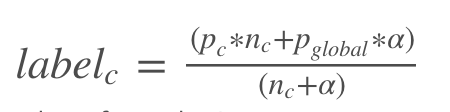

In [ ]:
# Script by https://www.kaggle.com/ogrellier
# Code: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None,
                  tst_series=None,
                  target=None,
                  min_samples_leaf=1,
                  smoothing=1,
                  noise_level=0):
    '''
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    '''
    
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    
    # Compute target mean
    averages = temp.groupby(trn_series.name)[target.name].agg(["mean", "count"])
    
    # Compute smoothing
    # sigmoid
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    
    prior = target.mean()
    
    # count가 클수록 full_avg는 적게 고려된다.
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    
    # trn과 tst에 series에 average 적용
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge는 index를 유지하지 않으므로 저장
    ft_trn_series.index = trn_series.index 
    
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge는 index를 유지하지 않으므로 저장
    ft_tst_series.index = tst_series.index
    
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

## Replace ps_car_11_cat with encoded value
**target_encode** 함수를 이용하여, **ps_car_11_cat**의 값을 바꿔줍니다

In [ ]:
train_encoded, test_encoded = target_encode(trainset["ps_car_11_cat"], 
                             testset["ps_car_11_cat"], 
                             target=trainset.target, 
                             min_samples_leaf=100,
                             smoothing=10,
                             noise_level=0.01)

trainset["ps_car_11_cat_te"] = train_encoded
trainset.drop("ps_car_11_cat", axis=1, inplace=True)
metadata.loc["ps_car_11_cat", "preserve"] = False
testset["ps_car_11_cat_te"] = test_encoded
testset.drop("ps_car_11_cat", axis=1, inplace=True)

## Balance target variable

target 칼럼의 데이터는 매우 불균형합니다. 이러한 경우, **target=0**을 undersampling하거나 **target=1**을 oversampling하여 개선할 수 있습니다. 여기선 train set가 매우 크기 때문에 **undersampling**을 해줍니다.

In [ ]:
desired_apriori = 0.1

idx_0 = trainset[trainset.target == 0].index
idx_1 = trainset[trainset.target == 1].index

nb_0 = len(trainset.loc[idx_0])
nb_1 = len(trainset.loc[idx_1])

undersampling_rate = ((1-desired_apriori) * nb_1) / (nb_0 * desired_apriori)
undersampled_nb_0 = int(undersampling_rate * nb_0)
print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

# 언더샘플링한 개수만큼 target=0인 데이터를 랜덤으로 선택
undersampled_idx = shuffle(idx_0, random_state=314, n_samples=undersampled_nb_0)

idx_list = list(undersampled_idx) + list(idx_1)

trainset = trainset.loc[idx_list].reset_index(drop=True)

## Replace -1 values with NaN

In [ ]:
trainset = trainset.replace(-1, np.nan)
testset = testset.replace(-1, np.nan)

## Dummify cat values
**categorical (cat)** 칼럼의 값들은 가변수화 해준다.

In [ ]:
cat_features = [a for a in trainset.columns if a.endswith("cat")]

for column in cat_features:
    temp = pd.get_dummies(pd.Series(trainset[column]))
    trainset = pd.concat([trainset, temp], axis=1)
    trainset = trainset.drop([column], axis=1)
    
for column in cat_features:
    temp = pd.get_dummies(pd.Series(testset[column]))
    testset = pd.concat([testset, temp], axis=1)
    testset = testset.drop([column], axis=1)

## Drop unused and target columns

**id**와 **target** 칼럼을 분리해줍니다. (이 칼럼들을 제거)

In [ ]:
id_test = testset['id'].values
target_train = trainset['target'].values

trainset = trainset.drop(['target','id'], axis = 1)
testset = testset.drop(['id'], axis = 1)

In [ ]:
print("Train dataset (rows, cols):",trainset.values.shape, "\nTest dataset (rows, cols):",testset.values.shape)

# Prepare the model

**cross validation과 앙상블을 위한 Ensemble 클래스**

4개의 변수를 가진다:

- **self** \-  초기화할 객체
- **n_splits** \- cross-validation 분할 수
- **stacker** \- 학습한 모델들로부터 나온 예측 결과들을 쌓는데 사용되는 모델
- **base_models** \- 훈련에 사용할 모델들의 리스트

<br>

두번째 메서드, **fit_predict**는 4개의 기능을 갖는다:

- **n_splits**의 개수로 training data를 나눈다
- 각각의 fold를 **base models**로 학습한다.
- 각각의 모델을 사용하여 예측을 수행한다.
- **stacker**를 이용하여 결과들을 앙상블

 **Roc 곡선과 이에 기반한 AUC 스코어:**
- 타깃이 되는 특성의 클래스 레이블 분포가 불균형할 때, accuracy의 단점을 보완하면서, decision boundary에 덜 민감하게 안정적으로 label을 더 잘 분류-예측할 수 있다는 장점이 있다
- 머신러닝의 이진 분류 모델의 성능을 판단하는 중요 지표
- ROC 곡선은 FPR(x 축)이 변할 때 TPR(y 축)이 어떻게 변하는지를 나타내는 곡선.
- 1에 가까울수록 좋은 수치
- TPR = (TP / (FN + TP))
- FPR = (FP / (FP + TN))

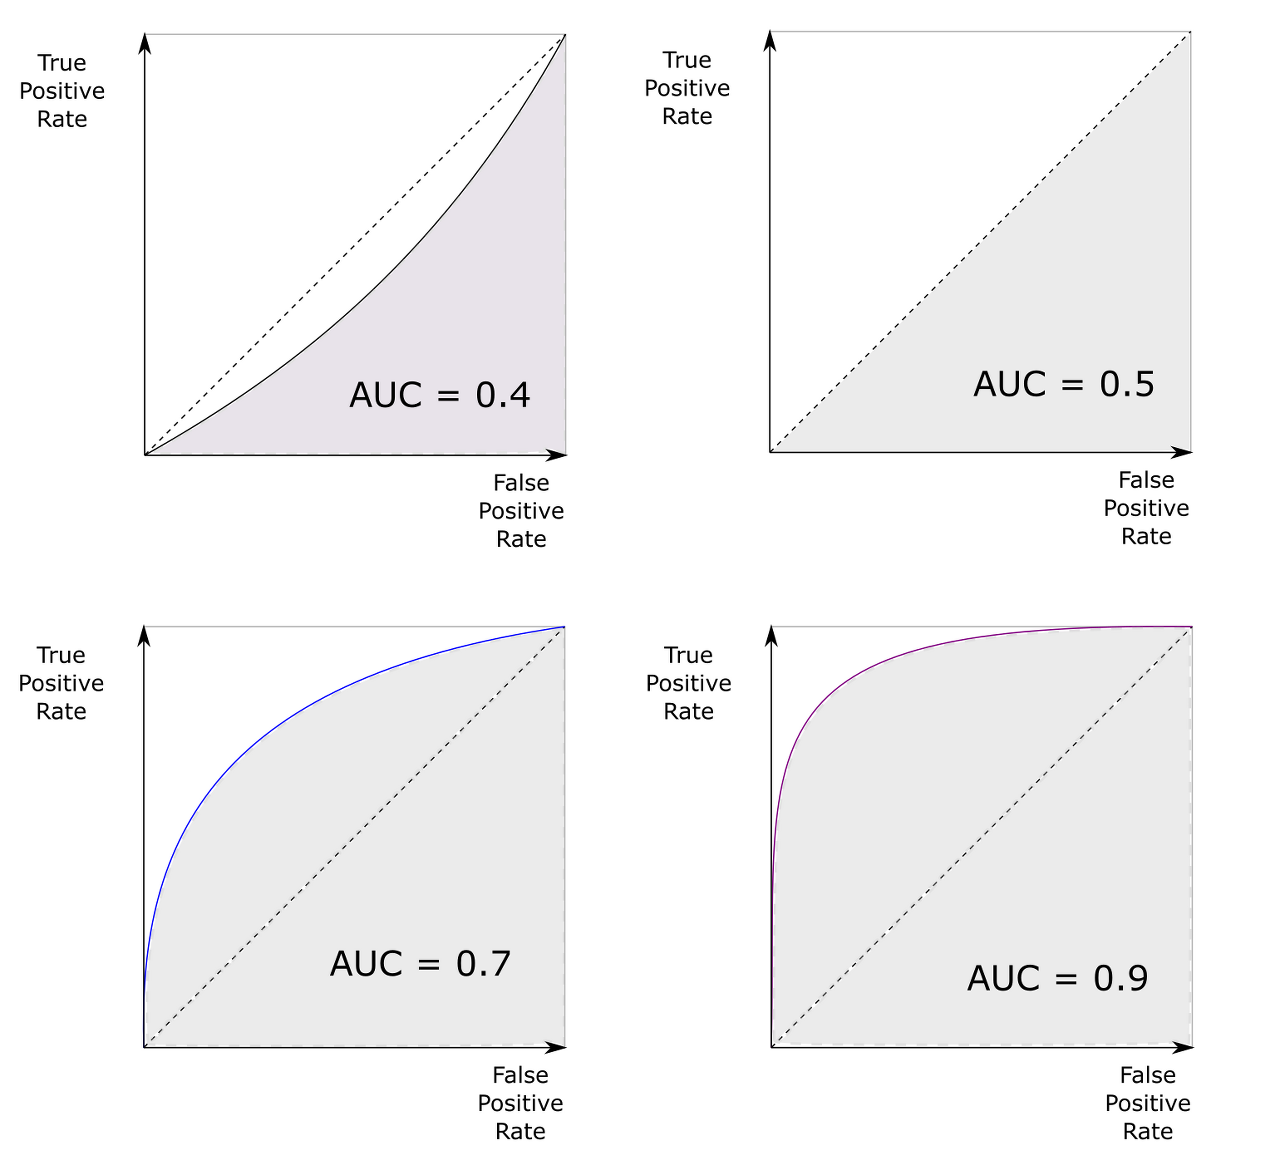

In [ ]:
class Ensemble(object):
    def __init__(self, n_splits, stacker, base_models):
        self.n_splits = n_splits
        self.stacker = stacker
        self.base_models = base_models
    
    def fit_predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)
        
        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, 
                                     random_state=314).split(X, y))
        
        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))
        
        for i, clf in enumerate(self.base_models):
            S_test_i = np.zeros((T.shape[0], self.n_splits))
            for j, (train_idx, test_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]
                
                print(str(clf))
                print ("Base model %d: fit %s model | fold %d" % (i+1, str(clf).split('(')[0], j+1))
                clf.fit(X_train, y_train)
                cross_score = cross_val_score(clf, X_train, y_train, cv=3, scoring="roc_auc")
                print("cross_score [roc-auc]: %.5f [gini]: %.5f" % (cross_score.mean(), 2*cross_score.mean()-1))
                
                y_pred = clf.predict_proba(X_holdout)[:, 1] # return: (n_samples, n_classes)
                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict_proba(T)[:, 1]
            S_test[:, i] = S_test_i.mean(axis=1)
            
        results = cross_val_score(self.stacker, S_train, y, cv=3, scoring="roc_auc")
        # Calculate gini factor as 2 * AUC - 1
        print("Stacker score [gini]: %.5f" % (2 * results.mean() - 1))
        self.stacker.fit(S_train, y)
        res = self.stacker.predict_proba(S_test)[:, 1]
        return res

## Parameters for the base models

3개의 다른 LightGBM 모델과 XGB 모델을 사용합니다

In [ ]:
# LightGBM params
# lgb_1
lgb_params1 = {}
lgb_params1['learning_rate'] = 0.02
lgb_params1['n_estimators'] = 650
lgb_params1['max_bin'] = 10
lgb_params1['subsample'] = 0.8
lgb_params1['subsample_freq'] = 10
lgb_params1['colsample_bytree'] = 0.8   
lgb_params1['min_child_samples'] = 500
lgb_params1['seed'] = 314
lgb_params1['num_threads'] = 4

# lgb2
lgb_params2 = {}
lgb_params2['n_estimators'] = 1090
lgb_params2['learning_rate'] = 0.02
lgb_params2['colsample_bytree'] = 0.3   
lgb_params2['subsample'] = 0.7
lgb_params2['subsample_freq'] = 2
lgb_params2['num_leaves'] = 16
lgb_params2['seed'] = 314
lgb_params2['num_threads'] = 4

# lgb3
lgb_params3 = {}
lgb_params3['n_estimators'] = 1100
lgb_params3['max_depth'] = 4
lgb_params3['learning_rate'] = 0.02
lgb_params3['seed'] = 314
lgb_params3['num_threads'] = 4

# XGBoost params
xgb_params = {}
xgb_params['objective'] = 'binary:logistic'
xgb_params['learning_rate'] = 0.04
xgb_params['n_estimators'] = 490
xgb_params['max_depth'] = 4
xgb_params['subsample'] = 0.9
xgb_params['colsample_bytree'] = 0.9  
xgb_params['min_child_weight'] = 10
xgb_params['num_threads'] = 4

## Initialize the models with the parameters

In [ ]:
# Base models
lgb_model1 = LGBMClassifier(**lgb_params1)

lgb_model2 = LGBMClassifier(**lgb_params2)
       
lgb_model3 = LGBMClassifier(**lgb_params3)

xgb_model = XGBClassifier(**xgb_params)

# Stacking model
log_model = LogisticRegression()

## Initialize the ensambling object

In [ ]:
stack = Ensemble(n_splits=3, stacker=log_model, 
                 base_models=(lgb_model1, lgb_model2, lgb_model3, xgb_model))  

# Run the predictive models

In [ ]:
y_prediction = stack.fit_predict(trainset, target_train, testset)

# Prepare the submission

In [ ]:
submission = pd.DataFrame()
submission["id"] = id_test
submission["target"] = y_prediction
submission.to_csv("stacked.csv", index=False)

# References
[1] Porto Seguro Safe Driver Prediction, Kaggle Competition, https://www.kaggle.com/c/porto-seguro-safe-driver-prediction

[2] Bert Carremans, Data Preparation and Exploration, Kaggle Kernel, https://www.kaggle.com/bertcarremans/data-preparation-exploration

[3] Head or Tails, Steering Whell of Fortune - Porto Seguro EDA, Kaggle Kernel, https://www.kaggle.com/headsortails/steering-wheel-of-fortune-porto-seguro-eda

[4] Anisotropic, Interactive Porto Insights - A Plot.ly Tutorial, Kaggle Kernel, https://www.kaggle.com/arthurtok/interactive-porto-insights-a-plot-ly-tutorial

[5] Dmitry Altukhov, Kaggle Porto Seguro's Safe Driver Prediction (3rd place solution), https://www.youtube.com/watch?v=mbxZ_zqHV9c

[6] Vladimir Demidov, Simple Staker LB 0.284, https://www.kaggle.com/yekenot/simple-stacker-lb-0-284

[7] Anisotropic, Introduction to Ensembling/Stacking in Python, https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python